# 1) Постановка задачи
В архиве находится 2 csv-файла с характеристиками квартир. Первый файл train.csv(10000 квартир) размечен, есть признаковое описание и целевая метка, второй файл test.csv(5000 квартир) имеет только признаковое описание.

Требуется построить модель регрессии и предсказать на тестовой выборке цену(Price) квартиры.

In [185]:
import pandas as pd
import seaborn as sns
from sklearn import model_selection, ensemble, preprocessing
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from matplotlib import pyplot as plt

# 2) Ход решения

In [197]:
# Загружаем данные
DataFrame = pd.read_csv('train.csv')
DataFrame.head(2)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.08904,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.00007,B,B,46,10309,1,240.0,1,16,B,300009.450063


Среди признаков есть 3 бинарных ('Ecology_2','Ecology_3', 'Ecology_3','Shops_2'), задачу уже прорешивал всякими способами, эти очень слабо коррелируют с целевой переменной, поэтому я решил их исключить

In [198]:
Binar_feach = DataFrame[['Ecology_2', 'Ecology_3','Shops_2']]
DataFrame = DataFrame.drop(['Ecology_2', 'Ecology_3','Shops_2'], axis=1, inplace=False)
DataFrame.head(2)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.08904,33,7976,5,NaN,0,11,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.00007,46,10309,1,240.0,1,16,300009.450063


Построим распределения признаков

In [172]:
# На вход функция принимает pd.DataFrame первым аргументом, вторым аргументом имя столбца, по которому будут размечены классы.
# Для задачи регрессии просто передаём DataFrame
def seaborn_plot(Data):
    sns.set(style="ticks")
    return (sns.pairplot(Data))

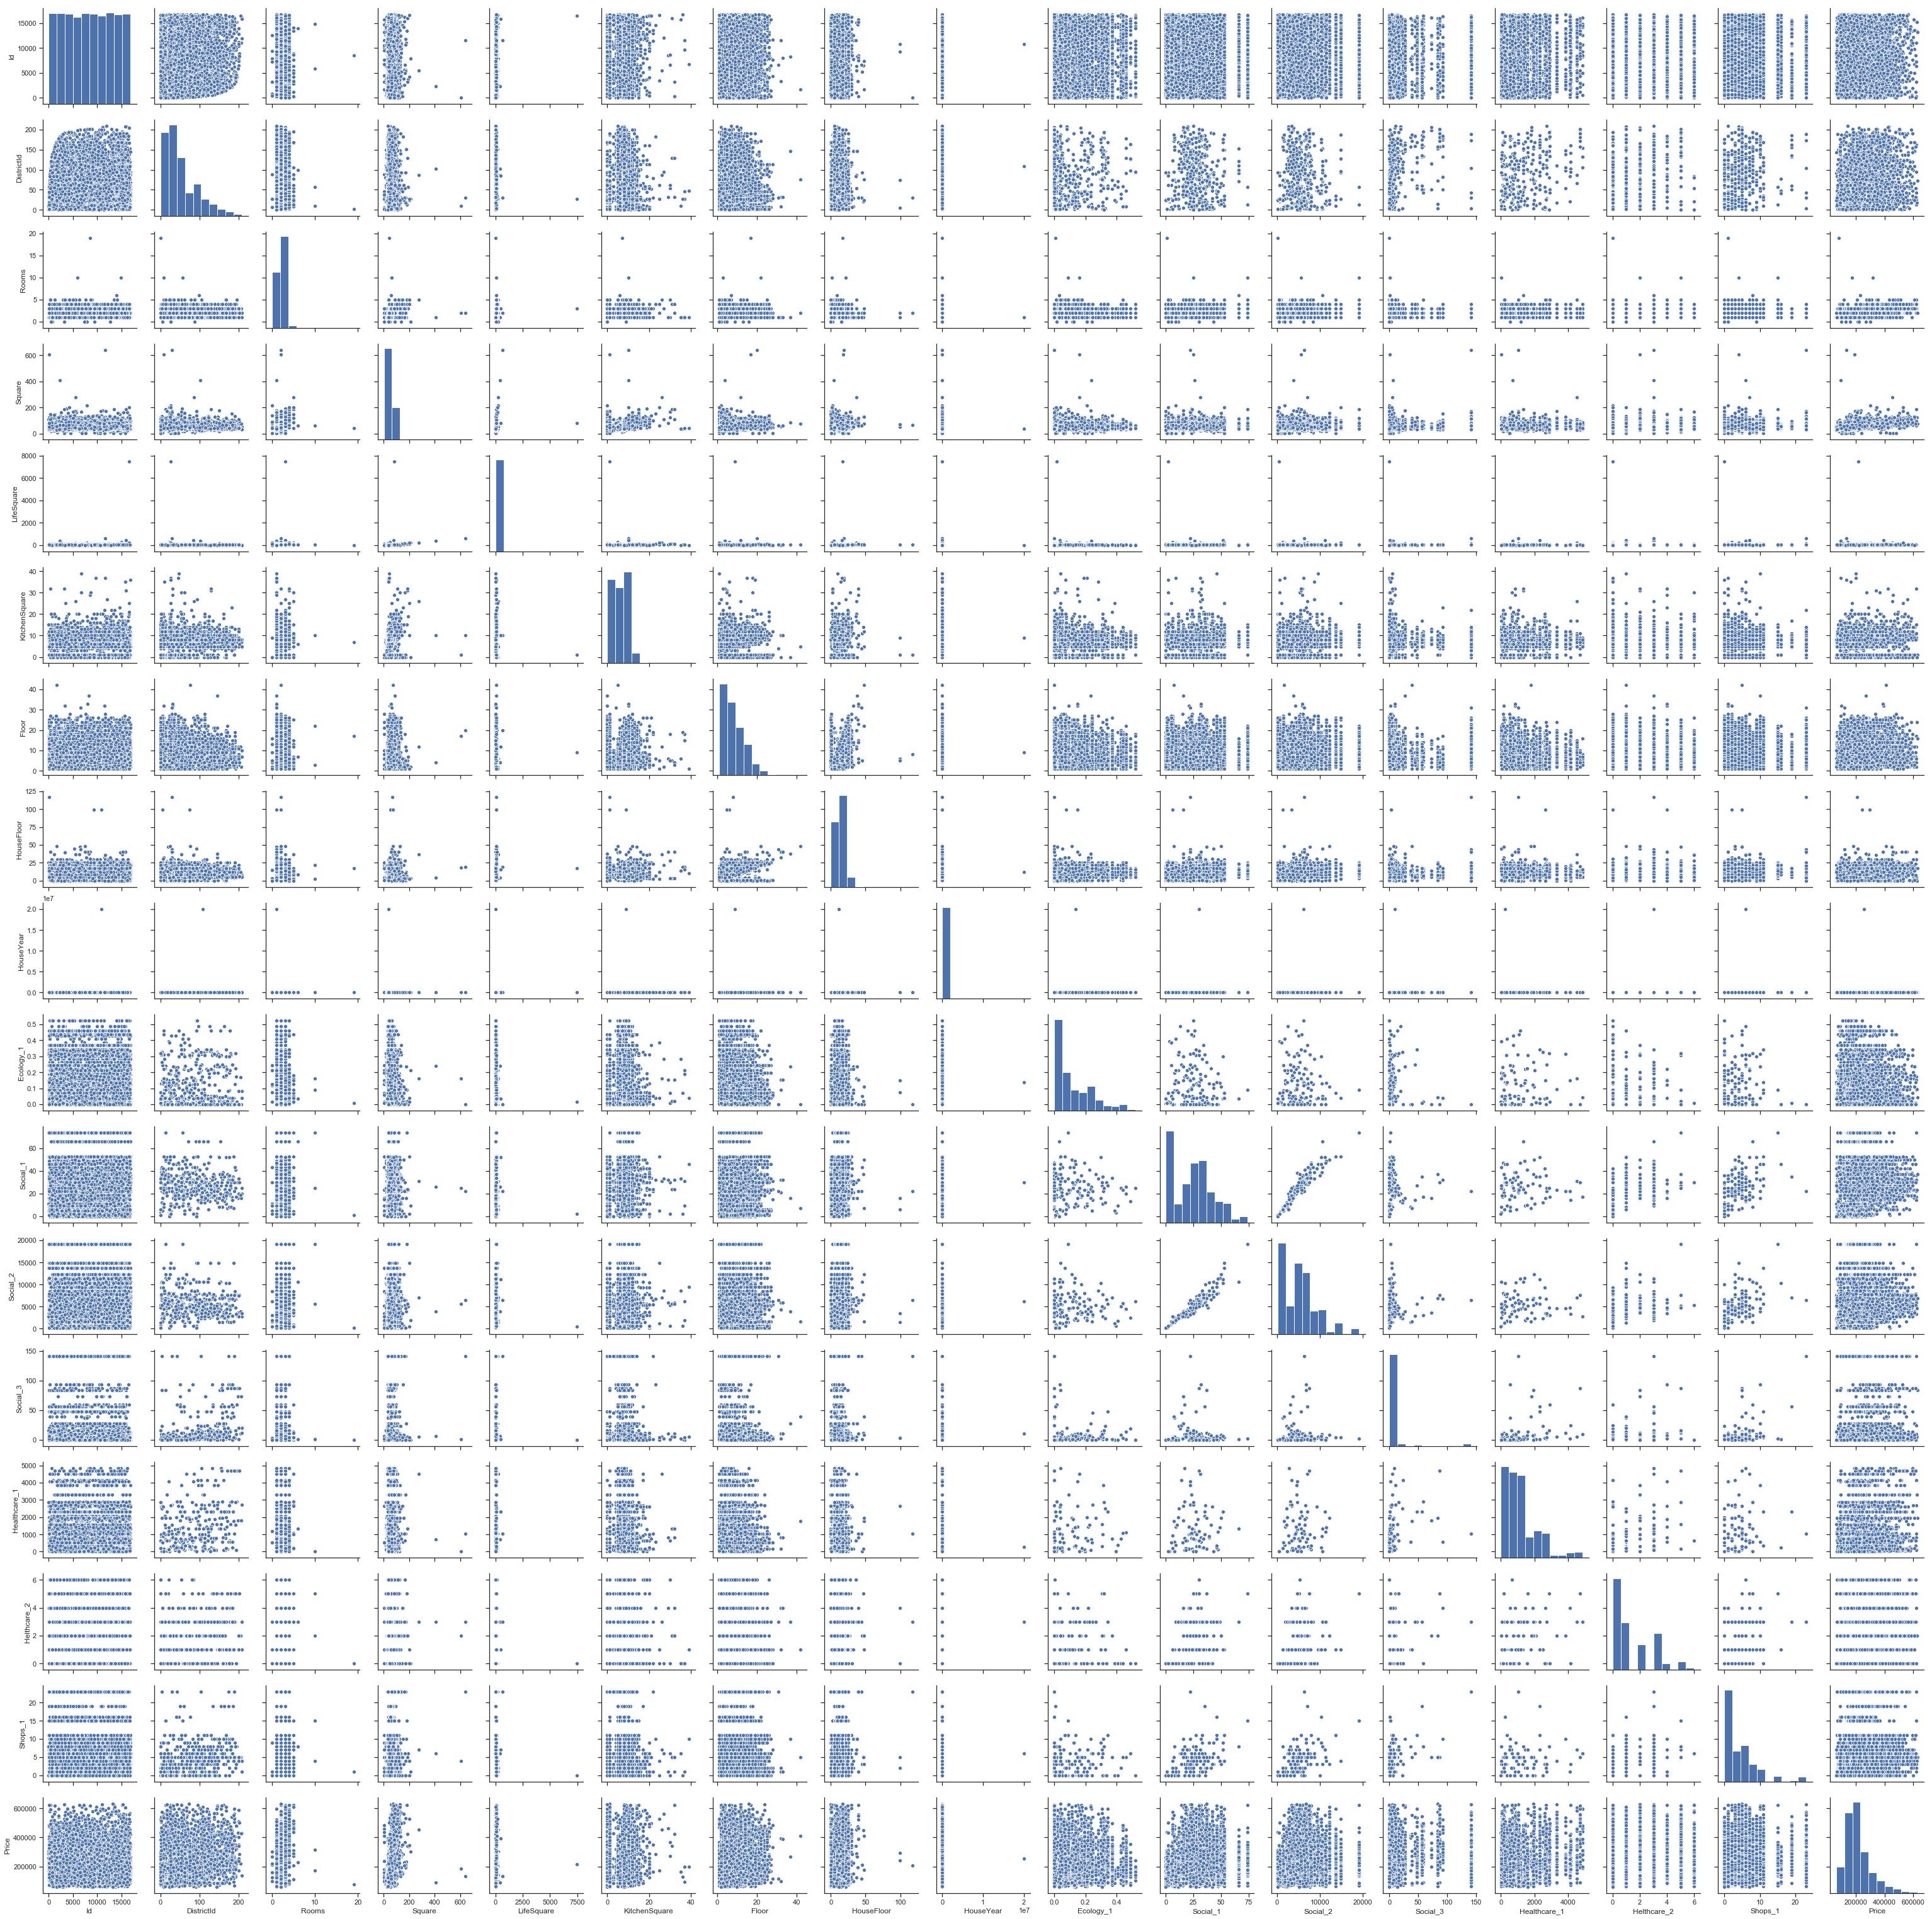

In [66]:
seaborn_plot(DataFrame)

Посмотрим на корреляцию признаков с целевой меткой

In [199]:
DataFrame.corr()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
Id,1.000000,0.012973,-0.005847,-0.010071,0.018449,0.019880,0.001348,-0.008376,0.005004,0.018097,-0.000772,-0.002033,-0.009358,-0.003879,0.001502,-0.008718,0.009880
DistrictId,0.012973,1.000000,0.071432,-0.026613,-0.019910,0.040358,-0.120373,-0.149051,0.013430,0.065294,0.246463,0.167479,0.136095,0.304335,0.306147,0.174214,0.265100
Rooms,-0.005847,0.071432,1.000000,0.662893,0.131336,0.005123,-0.000665,-0.029302,-0.010612,-0.032347,0.075980,0.071335,0.012811,0.042857,0.063557,0.053618,0.550291
Square,-0.010071,-0.026613,0.662893,1.000000,0.196129,0.008320,0.114791,0.081505,-0.009032,-0.064479,-0.070690,-0.043120,0.035241,-0.039748,-0.022960,0.021357,0.520075
LifeSquare,0.018449,-0.019910,0.131336,0.196129,1.000000,-0.001195,0.024559,0.027442,-0.002210,-0.023629,-0.048363,-0.039283,0.012763,-0.026867,-0.024762,-0.007569,0.081292
KitchenSquare,0.019880,0.040358,0.005123,0.008320,-0.001195,1.000000,-0.011397,0.000780,0.000958,-0.005622,0.043379,0.037805,-0.015140,0.009472,0.043170,0.010216,0.028864
Floor,0.001348,-0.120373,-0.000665,0.114791,0.024559,-0.011397,1.000000,0.418986,0.000928,-0.016133,-0.044914,-0.016560,-0.002237,-0.138294,-0.065537,0.024264,0.128715
HouseFloor,-0.008376,-0.149051,-0.029302,0.081505,0.027442,0.000780,0.418986,1.000000,-0.000864,-0.004362,-0.020801,0.007194,-0.008137,-0.143973,-0.068728,0.026279,0.088280
HouseYear,0.005004,0.013430,-0.010612,-0.009032,-0.002210,0.000958,0.000928,-0.000864,1.000000,0.001465,0.003026,0.001970,0.000819,-0.011969,0.011245,0.003681,0.004305
Ecology_1,0.018097,0.065294,-0.032347,-0.064479,-0.023629,-0.005622,-0.016133,-0.004362,0.001465,1.000000,0.026464,0.009264,-0.124068,-0.043547,0.030873,-0.076749,-0.058381


По корреляционной таблице видно, что больше всего с целевой метокой связаны такие признаки как Rooms, DistrictId, Square, Floor, Social_1, Social_2 и Helthcare_2.

Разделим DataFrame на категориальные, вещественные и бинарные признаки

In [237]:
X_bin=Binar_feach.fillna('NA', axis=0).applymap(str)# Все бинарные признаки преобразовали в строчный тип
# пустые значения заменили на  строку 'NA'
X_bin.Ecology_2[X_bin.Ecology_2=='B']=0
X_bin.Ecology_2[X_bin.Ecology_2=='A']=1

X_bin.Ecology_3[X_bin.Ecology_3=='B']=0
X_bin.Ecology_3[X_bin.Ecology_3=='A']=1

X_bin.Shops_2[X_bin.Shops_2=='B']=0
X_bin.Shops_2[X_bin.Shops_2=='A']=1


In [238]:
# Категориальные признаки
Categ_signs = DataFrame[['DistrictId', 'Rooms', 'KitchenSquare','Floor', 'HouseFloor','Social_1','Social_2',
                        'Social_3',
                        'Helthcare_2',
                        'Shops_1']]

In [239]:
# Вещественные признаки
Real_signs = DataFrame[['Id', 'Square','LifeSquare', 'HouseYear', 'Ecology_1', 'Healthcare_1' ]]
# Заменим пустые значения NaN на zero
Real_signs = Real_signs.apply(lambda x: x.fillna(x.mean()),axis=0)
# Выполним нормализацю признаков
Real_signs_norm = preprocessing.StandardScaler().fit(Real_signs)
Real_signs_norm = Real_signs_norm.transform(Real_signs)
pd.DataFrame(Real_signs_norm).head(2)

C:\Users\uraev.DESKTOP-H9FK1LE\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\uraev.DESKTOP-H9FK1LE\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys


,0,1,2,3,4,5
0,1.163789,-0.395780,-0.101285,-0.010081,-0.250529,0.000000
1,1.372690,0.444867,0.037212,-0.010036,-0.998053,-1.225611


In [240]:
# Обозначим целевую метку
y = DataFrame['Price'].values

После этого делал преобразование категориальных признаков, результат при обучении модели был хуже, оставил так.

In [241]:
# Объеденим категориальные признаки и нормализованные вещественные
X_cat_Real_bin = np.concatenate((Real_signs_norm, Categ_signs.values, X_bin), axis = 1)

In [242]:
# Делим данные на обучение и тест
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(X_cat_Real_bin, y, 
                                                                                    test_size = 0.3,
                                                                                    random_state = 1)

Далее написал функцию построения модели RandomForestRegressor с уже подобранными оптимальными гиперпараметрами

In [231]:
def build_model(train_data, train_labels):
    Regressor  = RandomForestRegressor(n_estimators = 150,
                                       max_depth = 17,
                                       random_state = 1,
                                       criterion = 'mse',
                                       min_samples_split = 2,
                                       min_samples_leaf = 1,
                                       min_weight_fraction_leaf = 0,
                                       max_features =  'sqrt',
                                       verbose=0,
                                       max_leaf_nodes = None,
                                       min_impurity_decrease = 10,
                                       bootstrap = False,
                                       n_jobs = -1)
    Regressor = Regressor.fit(train_data, train_labels)
    print('Обучение', r2_score(train_labels, Regressor.predict(train_data)))
    print('Тест', r2_score(test_labels, Regressor.predict(test_data)))
    print('CV', model_selection.cross_val_score(Regressor, X_cat_Real_bin, y, cv=5, scoring="r2").mean())
    print('mean_absolute_error', metrics.mean_absolute_error(test_labels, Regressor.predict(test_data)))
    return Regressor

In [232]:
Regressor = build_model(train_data, train_labels) 

Обучение 0.9901309793212567
Тест 0.7431536556953773
CV 0.7416017756877886
mean_absolute_error 27265.296115116547


Ниже функции, функции по которым перебирал каждый гиперпараметр

True
0.7200977382492221
False
0.7200977382492221


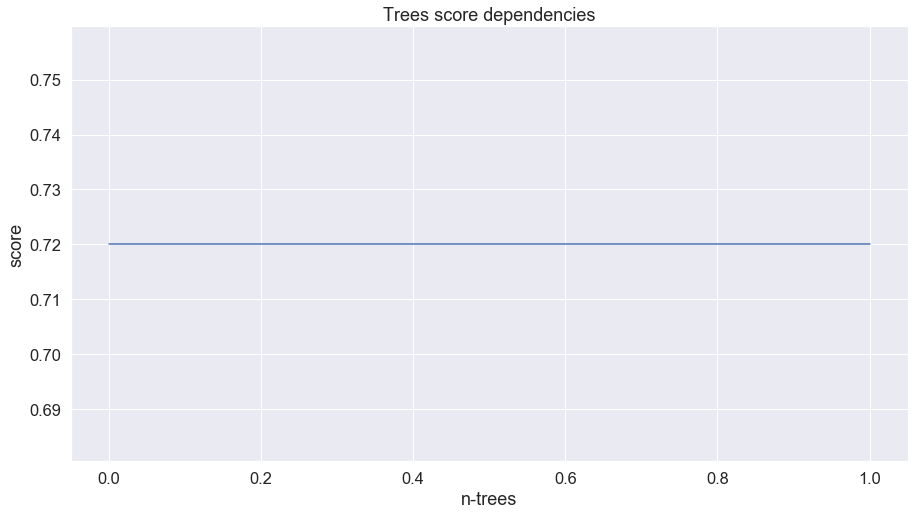

In [220]:
def fit_estimator(estimator):
    return model_selection.cross_val_score(estimator, X_cat_Real, y, cv=5).mean()
def plot_rf_trees_score():
    trees = [True, False]
    results = []
    for tree in trees:
        rf = RandomForestRegressor(n_estimators=150, max_depth = 10, random_state = 1, min_samples_split=2,
                                  min_samples_leaf =1,
                                  min_weight_fraction_leaf = 0,
                                  max_features =  'sqrt',
                                  max_leaf_nodes = None,
                                  min_impurity_decrease = 10, 
                                  min_impurity_split=1e-7,
                                  bootstrap = True,
                                  warm_start = tree,
                                  n_jobs=-1)
        print(tree)
        k = fit_estimator(rf)
        print(k)
        results.append(k)
    plt.figure(figsize=(15, 8))
    plt.plot(trees, results)
    plt.xlabel("n-trees")
    plt.ylabel("score")
    plt.title("Trees score dependencies")
    plt.show()
plot_rf_trees_score()

Ниже приведён график, который в случае идеальных предсказаний будет иметь вид диагонали, как на тестовых данных так на обучаемых

Populating the interactive namespace from numpy and matplotlib


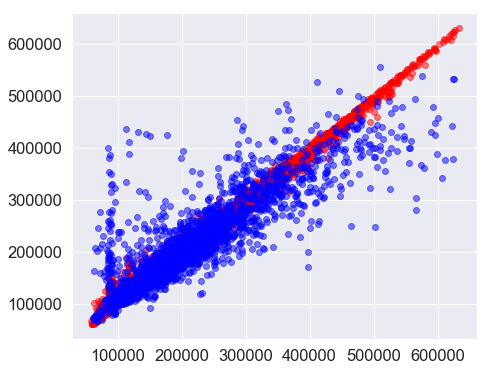

In [236]:
%pylab inline
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.scatter(train_labels, Regressor.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, Regressor.predict(test_data), alpha=0.5, color = 'blue')

# 3) Выводы по работе

В ходе работы, была построена модель RandomForestRegression для задачи прогнозирования цены на квартиру, качество на кросс валидации получилось 74% по метрике r2_score. На дефолтных параметрах модели качество было 70%, для его повышения были сделаны следующие шаги:
* 1) Нормализованы вещественные признаки
* 2) Категориальные оставил без изменений, так как применив к ним методы для категориальных признаков качество падает
* 3) Добавлены бинарные признаки

Для улучшения качества модели можно сделать следующее:
* 1) Улучшить набор признаков, выполнить какие-либо преобразования.
* 2) Удалить шумные неинформативные признаки.